In [1]:
# Example of a variational mixture of Gaussians.
# For a matlab version, see  https://github.com/probml/pmtk3/blob/master/demos/mixGaussVbDemoFaithful.m
# To run in colab, consider the following two lines
# > pip uninstall tensorflow -y -q
# > pip install -qq -Uq tfp-nightly[jax] > /dev/null
# Author: Gerardo Duran-Martin (@gerdm)

import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

import probml_utils.variational_mixture_gaussians as vmg
from probml_utils import savefig, latexify

from scipy import stats as scistats
from jax import random
import requests
from io import BytesIO

2022-07-28 18:23:56.715225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
# os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "figures"
latexify(width_scale_factor=3)

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:69: UserWarning: renaming figures/gmmvb-lower-bound.pdf to figures/gmmvb-lower-bound.png because LATEXIFY is False
  warnings.warn(


saving image to figures/gmmvb-lower-bound.png
Figure size: [6. 4.]


/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:69: UserWarning: renaming figures/gmmvb-cluster-it-1.pdf to figures/gmmvb-cluster-it-1.png because LATEXIFY is False
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:69: UserWarning: renaming figures/gmmvb-cluster-it-100.pdf to figures/gmmvb-cluster-it-100.png because LATEXIFY is False
  warnings.warn(


saving image to figures/gmmvb-cluster-it-1.png
Figure size: [6. 4.]
saving image to figures/gmmvb-cluster-it-100.png
Figure size: [6. 4.]
saving image to figures/gmmvb-alpha-dist-1.png


/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:69: UserWarning: renaming figures/gmmvb-alpha-dist-1.pdf to figures/gmmvb-alpha-dist-1.png because LATEXIFY is False
  warnings.warn(
/home/gerardoduran/miniconda3/lib/python3.9/site-packages/probml_utils/plotting.py:69: UserWarning: renaming figures/gmmvb-alpha-dist-100.pdf to figures/gmmvb-alpha-dist-100.png because LATEXIFY is False
  warnings.warn(


Figure size: [6. 4.]
saving image to figures/gmmvb-alpha-dist-100.png
Figure size: [6. 4.]


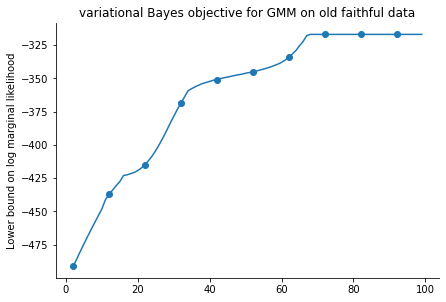

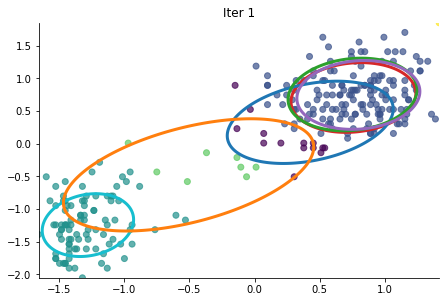

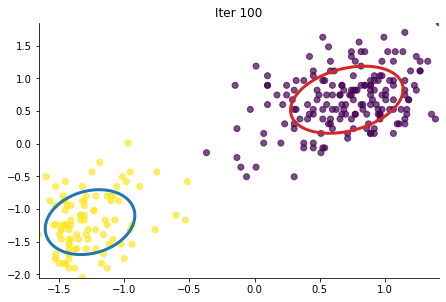

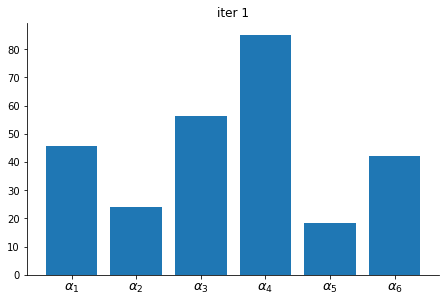

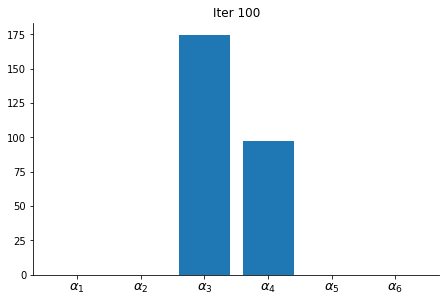

In [3]:
url = "https://raw.githubusercontent.com/probml/probml-data/main/data/faithful.txt"
response = requests.get(url)
rawdata = BytesIO(response.content)


def plot_mixtures(X, r, mu, pi, Sigma, ax, step=0.01, cmap="viridis", levels=1):
    colors = ["tab:red", "tab:blue", "tab:green", "tab:cyan", "tab:orange", "tab:purple"]
    x0, y0 = X.min(axis=0)
    x1, y1 = X.max(axis=0)
    xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
    zdom = np.c_[xx.ravel(), yy.ravel()]
    Nk = r.sum(axis=0)

    # Plotting distributions whose effective number of
    # observations is at least 1
    Norms = [scistats.multivariate_normal(mean=mui, cov=Sigmai) for mui, Sigmai, N in zip(mu, Sigma, Nk) if N > 1]

    for Norm, color in zip(Norms, colors):
        density = Norm.pdf(zdom).reshape(xx.shape)
        ax.contour(xx, yy, density, levels=levels, colors=color, linewidths=3)

    ax.scatter(*X.T, alpha=0.7, c=r.argmax(axis=1), cmap=cmap)
    plt.xlim(x0, x1)
    plt.ylim(y0, y1)


if __name__ == "__main__":
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False

    data = jnp.array(np.loadtxt(rawdata))
    X = (data - data.mean(axis=0)) / data.std(axis=0)
    # Prior parameters
    key = random.PRNGKey(3141)
    N, M = X.shape
    K = 6

    m_0 = X.mean(axis=0, keepdims=True).T * jnp.ones((M, K))
    m_0 = m_0 + random.normal(key, (M, K))

    beta_0 = jnp.ones(K)
    alpha_0 = jnp.ones(K) * 0.001
    eta_0 = 4 * jnp.ones(K)

    W_0 = jnp.eye(M)[None, ...] * jnp.ones((K, 1, 1)) / 5

    vbmixture = vmg.VBMixture()
    n_iterations = 100
    hist = vbmixture.fit(X, m_0, W_0, beta_0, alpha_0, eta_0, n_iterations, store_hist=True)
    iterations_range = np.arange(n_iterations)

    fig, ax = plt.subplots()
    ax.plot(iterations_range[2:], vbmixture.lower_bound_hist[2:])
    ax.scatter(iterations_range[2::10], vbmixture.lower_bound_hist[2::10])
    ax.set_title("variational Bayes objective for GMM on old faithful data")
    ax.set_ylabel("Lower bound on log marginal likelihood")
    pml.savefig("gmmvb-lower-bound.pdf")

    fig, ax = plt.subplots()
    it1 = hist[1]
    pi_k, mu_k, Sigma_k = vbmixture.expected_values(it1)
    r_nk = vbmixture.compute_responsibilities(X, it1["alpha"], it1["beta"], it1["eta"], it1["m"], it1["W"])
    plot_mixtures(X, r_nk, mu_k, pi_k, Sigma_k, ax, levels=1)
    ax.set_title(f"Iter 1")
    pml.savefig("gmmvb-cluster-it-1.pdf")

    fig, ax = plt.subplots()
    pi_k, mu_k, Sigma_k = vbmixture.expected_values()
    plot_mixtures(X, vbmixture.r_nk, mu_k, pi_k, Sigma_k, ax, levels=1)
    ax.set_title(f"Iter {n_iterations}")
    pml.savefig(f"gmmvb-cluster-it-{n_iterations}.pdf")

    fig, ax = plt.subplots()
    ax.bar(np.arange(K), it1["alpha"])
    ax.set_xticks(range(K))
    ax.set_xticklabels([r"$\alpha_" f"{k+1}$" for k in range(K)], fontsize=13)
    ax.set_title("iter 1")
    pml.savefig("gmmvb-alpha-dist-1.pdf")

    fig, ax = plt.subplots()
    ax.bar(np.arange(K), vbmixture.alpha_k)
    ax.set_xticks(range(K))
    ax.set_xticklabels([r"$\alpha_" f"{k+1}$" for k in range(K)], fontsize=13)
    ax.set_title("Iter 100")
    pml.savefig(f"gmmvb-alpha-dist-{n_iterations}.pdf")

    plt.show()